### Fairlearn correlation remover

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

sns.set_theme(style="darkgrid", context= "paper")

In [2]:
pickle_file_path = "C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/subsets_data.pickle"

with open(pickle_file_path, 'rb') as f:
    subsets = pickle.load(f)

X_train_scaled = subsets['X_train_scaled']
X_test_scaled = subsets['X_test_scaled']
X_val_scaled = subsets['X_val_scaled']
y_train = subsets['y_train']
y_test = subsets['y_test']
y_val = subsets['y_val']

In [3]:
X_column_names = ['county_code', 'interest_rate', 'loan_to_value_ratio',
       'applicant_sex_Female', 'applicant_race-1_White', 'loan_type_FHA',
       'loan_type_VA', 'loan_type_FSA/RHS', 'debt_to_income_ratio_20%-<30%',
       'debt_to_income_ratio_30%-<36%-41%%', 'debt_to_income_ratio_36%-41%',
       'debt_to_income_ratio_41%-45%', 'debt_to_income_ratio_46%-49%',
       'debt_to_income_ratio_50%-60%', 'debt_to_income_ratio_<20%',
       'debt_to_income_ratio_>60%', 'debt_to_income_ratio_missing',
       'lien_status_Subordinate lien']

X_column_names_trans = X_column_names.copy()
X_column_names_trans.remove('applicant_race-1_White')

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_column_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_column_names)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_column_names)

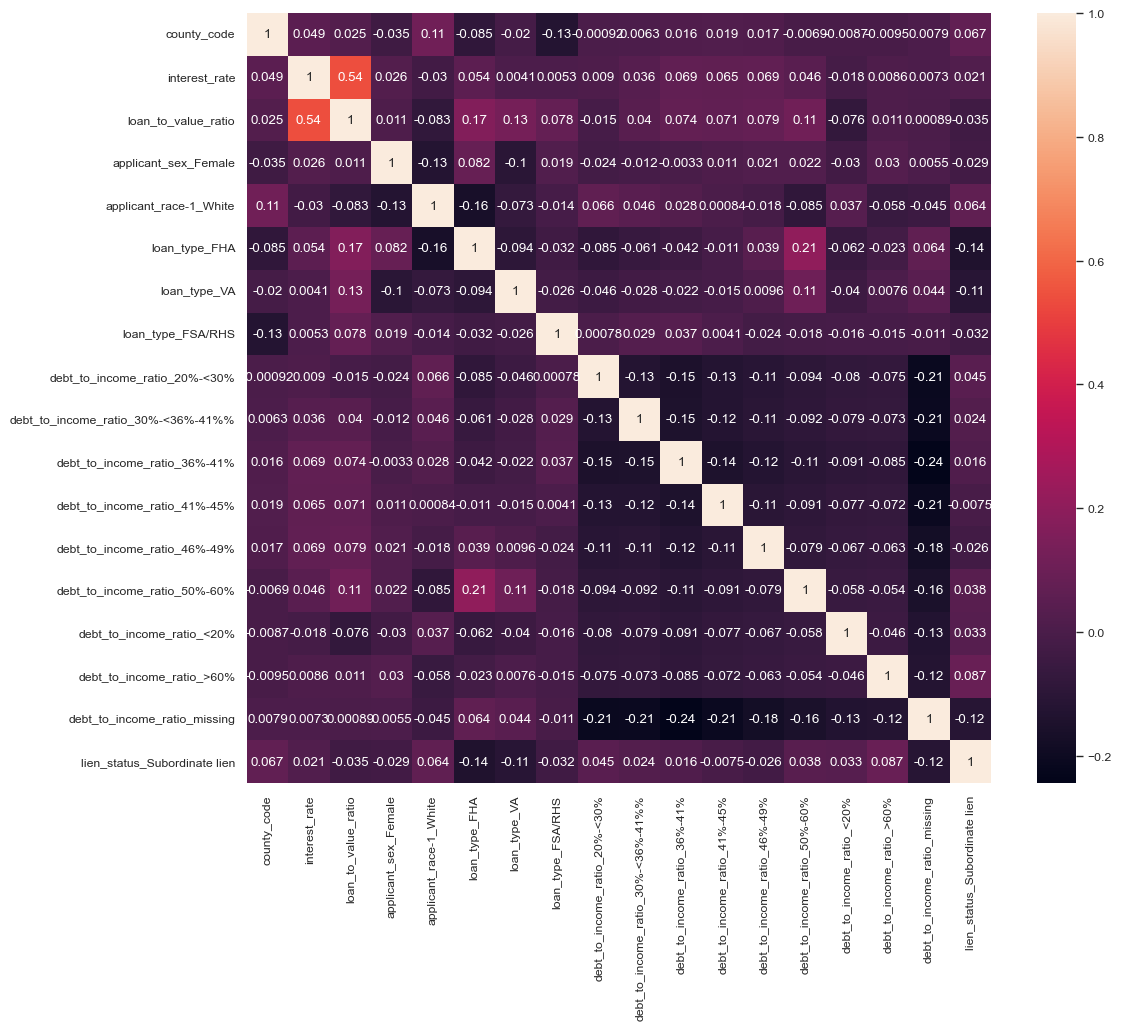

In [4]:
corr = X_train_scaled_df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True)
plt.show()

In [5]:
from fairlearn.preprocessing import CorrelationRemover

cr = CorrelationRemover(sensitive_feature_ids=['applicant_race-1_White'])
cr.fit(X_train_scaled_df)
X_train_scaled_transform = cr.transform(X_train_scaled_df)

In [6]:
cr.fit(X_test_scaled_df)
X_test_scaled_transform = cr.transform(X_test_scaled_df)
X_test_scaled_transform = pd.DataFrame(X_test_scaled_transform, columns=X_column_names_trans)
X_test_scaled_transform["applicant_race-1_White"] = X_test_scaled_df["applicant_race-1_White"]

cr.fit(X_val_scaled_df)
X_val_scaled_transform = cr.transform(X_val_scaled_df)
X_val_scaled_transform = pd.DataFrame(X_val_scaled_transform, columns=X_column_names_trans)
X_val_scaled_transform["applicant_race-1_White"] = X_val_scaled_df["applicant_race-1_White"]

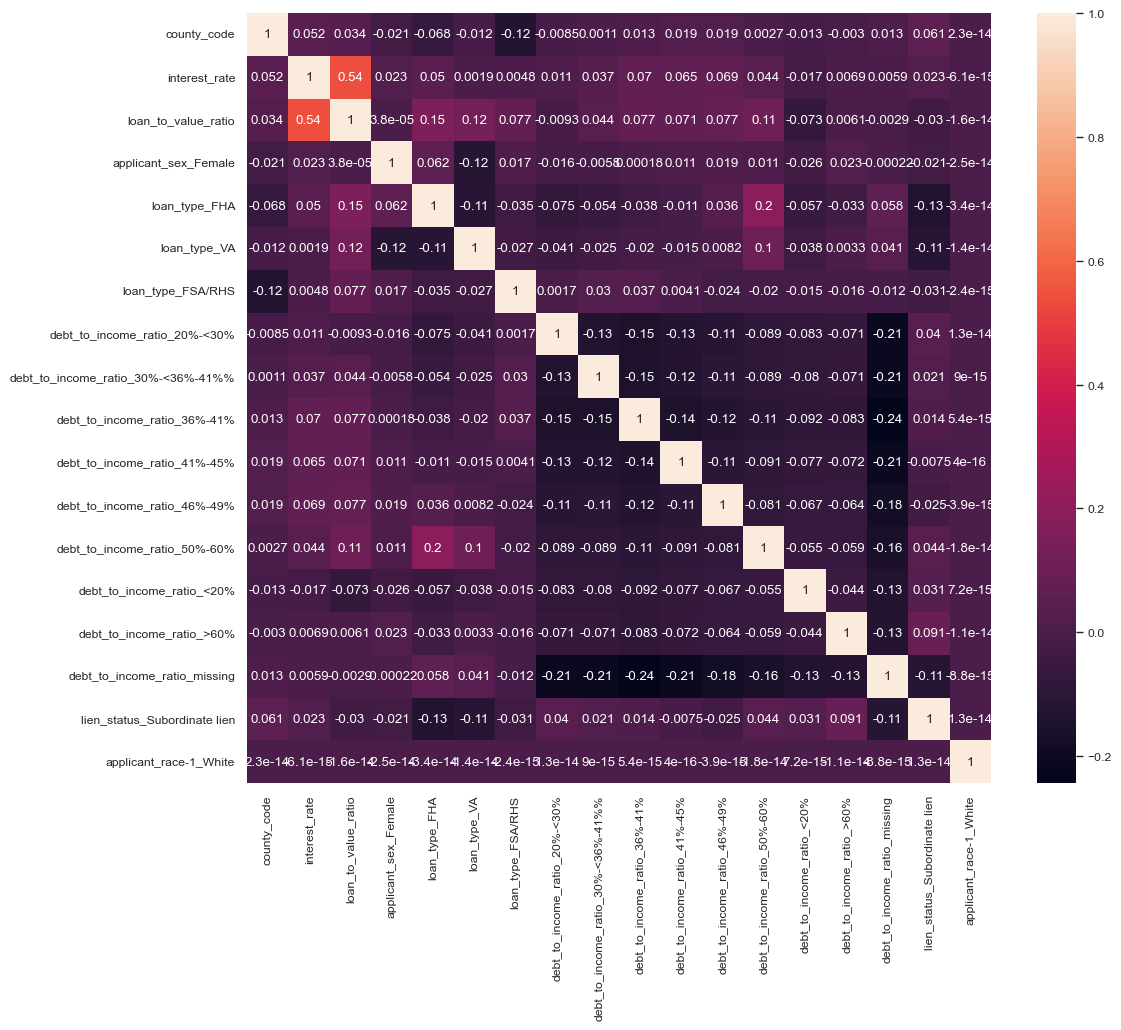

In [7]:
X_train_scaled_transform = pd.DataFrame(X_train_scaled_transform, columns=X_column_names_trans)
X_train_scaled_transform["applicant_race-1_White"] = X_train_scaled_df["applicant_race-1_White"]
corr_cr = X_train_scaled_transform.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_cr, annot=True)
plt.show()

In [8]:
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model = keras.Sequential([
    keras.layers.Dense(32, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001), input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = model.fit(X_train_scaled_transform, y_train, validation_data=(X_val_scaled_transform, y_val), epochs=30, batch_size=48, callbacks=[early_stopping, model_checkpoint])

Epoch 1/30
11360/11360 [==============================] - 76s 6ms/step - loss: 0.3465 - accuracy: 0.8752 - val_loss: 0.3077 - val_accuracy: 0.8915
Epoch 2/30
11360/11360 [==============================] - 67s 6ms/step - loss: 0.3021 - accuracy: 0.8941 - val_loss: 0.3034 - val_accuracy: 0.8919
Epoch 3/30
11360/11360 [==============================] - 75s 7ms/step - loss: 0.2958 - accuracy: 0.8965 - val_loss: 0.2926 - val_accuracy: 0.8944
Epoch 4/30
11360/11360 [==============================] - 76s 7ms/step - loss: 0.2922 - accuracy: 0.8977 - val_loss: 0.2830 - val_accuracy: 0.9011
Epoch 5/30
11360/11360 [==============================] - 68s 6ms/step - loss: 0.2906 - accuracy: 0.8983 - val_loss: 0.2800 - val_accuracy: 0.9018
Epoch 6/30
11360/11360 [==============================] - 43s 4ms/step - loss: 0.2899 - accuracy: 0.8988 - val_loss: 0.2825 - val_accuracy: 0.9024
Epoch 7/30
11360/11360 [==============================] - 43s 4ms/step - loss: 0.2897 - accuracy: 0.8987 - val_loss: 0

5325/5325 - 10s - loss: 0.2805 - accuracy: 0.9031 - 10s/epoch - 2ms/step

Test accuracy: 0.9030741453170776


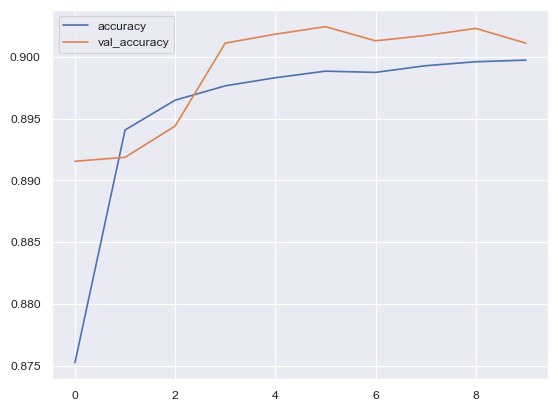

In [9]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

test_loss, test_acc = model.evaluate(X_test_scaled_transform, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

5325/5325 [==============================] - 10s 2ms/step
[[58926 12722]
 [ 3793 94947]]
Accuracy: 0.9030741601521234
Precision: 0.8818415699969351
Recall: 0.9615859833907231
F1 Score: 0.9199889539700304
AUC: 0.9428068146418431


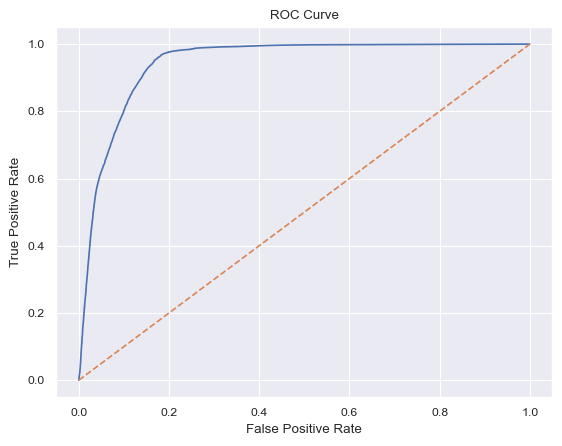

In [10]:
y_pred_proba = model.predict(X_test_scaled_transform)
y_pred = (y_pred_proba > 0.5)
y_pred_proba = y_pred_proba.ravel()

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

from sklearn.metrics import roc_auc_score
print("AUC:", roc_auc_score(y_test, y_pred_proba))

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

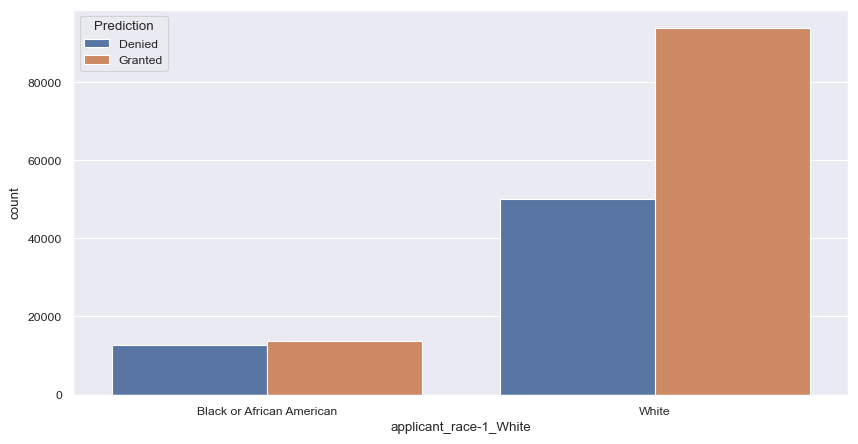

In [11]:
prediction_df = X_test_scaled_transform.copy()
prediction_df['prediction'] = y_pred
prediction_df['prediction_proba'] = y_pred_proba

plt.figure(figsize=(10, 5))
sns.countplot(data=prediction_df, x = "applicant_race-1_White", hue = "prediction")
plt.legend(title = "Prediction", labels = ["Denied", "Granted"])
plt.xticks(ticks=[0, 1], labels=["Black or African American", "White"])
plt.show()

### AIF Adversarial Debiasing
https://github.com/Trusted-AI/AIF360/blob/main/examples/demo_adversarial_debiasing.ipynb

In [12]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector
from aif360.algorithms.inprocessing.adversarial_debiasing import AdversarialDebiasing

pip install 'aif360[inFairness]'


In [20]:
BLD_train_df = pd.read_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/BLD_train_df.pkl")
BLD_test_df = pd.read_pickle("C:/Users/Hauke/OneDrive - ucp.pt/04_Thesis/00_GitHub/Thesis/data/interim/BLD_test_df.pkl")

privileged_groups = [{'applicant_race-1_White': 1}]
unprivileged_groups = [{'applicant_race-1_White': 0}]

train_bld = BinaryLabelDataset(df=BLD_train_df, label_names=['loan_granted'], protected_attribute_names=['applicant_race-1_White', 'applicant_race-1_Black or African American'], favorable_label=1.0, unfavorable_label=0.0)
test_bld = BinaryLabelDataset(df=BLD_test_df, label_names=['loan_granted'], protected_attribute_names=['applicant_race-1_White', 'applicant_race-1_Black or African American'], favorable_label=1.0, unfavorable_label=0.0)

metric_orig_train = BinaryLabelDatasetMetric(train_bld, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Original Training Data")
print("Train set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

metric_orig_test = BinaryLabelDatasetMetric(test_bld, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
print("Original Test Data")
print("Test set: Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_test.mean_difference())

Original Training Data
Train set: Difference in mean outcomes between unprivileged and privileged groups = -0.148808
Original Test Data
Test set: Difference in mean outcomes between unprivileged and privileged groups = -0.149177
